In [4]:
from notebook_functions import *
import warnings
warnings.filterwarnings("ignore")
import cartopy.geodesic as cgeo

In [5]:
stash_dict={"sm":"STASH_m01s08i223",
            "lhfx":"STASH_m01s03i234",
            "shfx":"STASH_m01s03i217",
            "t2":"STASH_m01s03i236",
            "q2":"STASH_m01s03i237",
            "lw_nsfc":"STASH_m01s02i201",
            "sw_nsfc":"STASH_m01s01i201"
           }

In [6]:
### FUNCTION FOR LOADING IN RAW DATA FILES - not actually used in this script, included as example.
def load_file(sim,date,hour,file_list,var):
    date_str="2006%02d%02d" % (date.month,date.day)
    hour=hour-1 #filenames are 1 hour BEHIND data timestamp
    date_str2=date_str
    if hour>23:
        hour=hour-24
        if sim=="control" or sim=="sens" and hour>5:
            date=date+datetime.timedelta(days=1)
            date_str2="2006%02d%02d" % (date.month,date.day)
        elif sim=="sens" and hour<=5:
            date_str2="2006%02d%02d" % (date.month,date.day)
            date=date+datetime.timedelta(days=1)
    if hour>23:
        hour=hour-24
        if sim=="sens":
            date_str2="2006%02d%02d" % (date.month,date.day)
        date=date+datetime.timedelta(days=1)
        if sim=="control":
            date_str2="2006%02d%02d" % (date.month,date.day)
    exp_str="2006%02d%02d" % (date.month,date.day)

    if sim=="sens":
        #root_str="/gws/nopw/j04/lmcs/filtered_soil_moisture_runs/u-da520/20060725T0500Z/Sahel/4km/RA3/um/"
        root_str=glob.glob("/gws/nopw/j04/lmcs/sensitivity_runs_wg_mcs/{}T0600Z/*/{}T0600Z/Sahel/1p5km/RA3/um/".format(date_str,date_str2))[0]
    elif sim=="control":
        root_str="/gws/nopw/j04/lmcs/u-cy045_control_run/u-cy045/{}T0000Z/Sahel/1p5km/RA3/um/".format(date_str2)

    if file_list=="sensible_hfx_control":
        data=xr.open_dataset("/gws/nopw/j04/lmcs/bmaybee/sensible_heat_fluxes/{}_sensible_heat_flux.nc".format(date_str2))["surface_upward_sensible_heat_flux"
        ].sel(longitude=slice(348,378),latitude=slice(9,19)).isel(time=slice(hour,hour+1)) # Sahel - time slice necessary to keep length 1 time axis.
        return data.rename({"longitude":"lon","latitude":"lat"})

    elif sim=="sens" and date_str==exp_str and hour==5:
        data=xr.open_dataset("/gws/nopw/j04/lmcs/bmaybee/Filtered_SM_initialisations/{}_05Z_SM_filter_wg_mcs.nc".format(date_str))[var].sel(
                            grid_longitude_t=slice(348,378),grid_latitude_t=slice(9,19)).isel(ATM_SOIL=0)
        return data.rename({"grid_longitude_t":"lon","grid_latitude_t":"lat"})
            
    else:
        data=xr.open_dataset(root_str+"{}_{}_T{:02d}.nc".format(file_list,exp_str,hour))[var].sel(
                        grid_longitude_t=slice(348,380),grid_latitude_t=slice(8,28)) # Very big area, but crucially avoids all coastlines
        data=data.sel(grid_longitude_t=slice(348,378),grid_latitude_t=slice(9,19)) # RESTRICT TO CORE SAHEL
    
        if file_list=="soil_moistures":
            data=data.isel(ATM_SOIL=0)
        try:
            data=data.isel(height_1_5m=0)
        except:
            pass
        return data.rename({"grid_longitude_t":"lon","grid_latitude_t":"lat"})

In [49]:
# get soil moisture field from sensitivity run at 18UTC on day 1 - would do hour=42 for 18UTC on day 2.
example=load_file("sens",pd.Timestamp("2006-07-28"),5,"surface_vars",stash_dict["q2"])[0,:,:]
example.plot() # note function set to load Sahel subdomain only. Tracking done on full domain.

base date 20060728 real date 20060728
loading /gws/nopw/j04/lmcs/sensitivity_runs_wg_mcs/20060728T0600Z/u-dd496/20060728T0600Z/Sahel/1p5km/RA3/um/surface_vars_20060728_T04.nc


FileNotFoundError: [Errno 2] No such file or directory: b'/gws/nopw/j04/lmcs/sensitivity_runs_wg_mcs/20060728T0600Z/u-dd496/20060728T0600Z/Sahel/1p5km/RA3/um/surface_vars_20060728_T04.nc'

In [9]:
# back to tracking!
MCS_data=pd.read_csv("~/LMCS/LMCS_Wafrica_sim/storm_tracking/Tables/Control_run_MCS_tracks_rain.csv")
MCS_data["sim_start"]=MCS_data.start_time.iloc[0]
MCS_data["sim_end"]=MCS_data.start_time.iloc[-1]

In [10]:

ref_olr=xr.open_dataset('/gws/nopw/j04/lmcs/u-cy045_control_run/u-cy045/20060725T0000Z/Sahel/1p5km/RA3/um/surface_vars_20060725_T01.nc'
                       ).STASH_m01s02i205[:2200,:3300]
ref_olr=ref_olr.assign_coords(longitude=ref_olr.grid_longitude_t-360)
ref_lons=ref_olr.grid_longitude_t
ref_lats=ref_olr.grid_latitude_t

ref_lons=np.linspace(-18,35,3300)
ref_lats=np.linspace(0,25,2200)

In [11]:
def calc_mean_speeds(storm_data,is_mcs=True):        
    prop_data = {"mcs":[],"ltime":[],"speeds":[],"dirs":[]}
    geo=cgeo.Geodesic()
    for i in range(len(storm_data)):
        storm_locs=storm_data.iloc[i].dropna()
        #MCS area threshold; 11km ~ 0.1 degree resolution of k-scale gws analysis grid. Change if different!
        is_mcs = storm_locs.filter(regex="area").where(storm_locs.filter(regex="area") > 5000/1.5**2).dropna()
        #NInclude cutoff to remove storms that only pop over MCS threshold once, can pollute tracking stats
        if len(is_mcs) > 1:
            prop_data["mcs"].append(storm_locs.name)
            prop_data["ltime"].append(len(is_mcs))

            #Get mean storm speeds; geodesic distance between start and end centroids / lifetime.
            storm_locs=storm_locs.filter(regex="idx")
            start_lon, start_lat = ref_lons[int(storm_locs.iloc[0])], ref_lats[int(storm_locs.iloc[1])]
            end_lon, end_lat = ref_lons[int(storm_locs.iloc[-2])], ref_lats[int(storm_locs.iloc[-1])]
            
            path=cgeo.Geodesic.inverse(geo,np.array((start_lon,start_lat)),np.array((end_lon,end_lat)))
        
            prop_data["speeds"].append(path[0,0] / (3600*len(storm_locs)/2))
            prop_data["dirs"].append(path[0,1])

    storm_prop=pd.DataFrame(prop_data)
    storm_prop.index = storm_prop["mcs"]
    storm_prop["dirs"][storm_prop["dirs"]<0] = storm_prop["dirs"][storm_prop["dirs"]<0] + 360

    return storm_prop

In [12]:
MCS_props=calc_mean_speeds(MCS_data)

In [13]:
sens_data=[]
sens_data_day1,sens_data_day2=[],[]
for ffile in glob.glob("/home/users/bmaybee/LMCS/LMCS_Wafrica_sim/storm_tracking/Tables/sensitivity_runs_wg_mcs/*rain.csv"):
    dayfile=pd.read_csv(ffile)
    dayfile = dayfile[dayfile.columns.drop(list(dayfile.filter(regex='rain')))]
    dayfile["start_time"]=pd.to_datetime(dayfile["start_time"])
    dayfile["sim_start"]=dayfile.start_time.iloc[0]
    dayfile["sim_end"]=dayfile.start_time.iloc[0]+pd.Timedelta(2,"d")
    sens_data.append(dayfile)
    init_time=dayfile.start_time.iloc[0]
    sens_data_day1.append(dayfile[(dayfile["start_time"]-init_time).dt.days<1])
    sens_data_day2.append(dayfile[(dayfile["start_time"]-init_time).dt.days>=1])

sens_data=pd.concat(sens_data)
sens_data=sens_data.reset_index(drop=True)
sens_data=sens_data.sort_values(by="start_time")

sens_data_day1=pd.concat(sens_data_day1)
sens_data_day1=sens_data_day1.reset_index(drop=True)
sens_data_day1=sens_data_day1.sort_values(by="start_time")

sens_data_day2=pd.concat(sens_data_day2)
sens_data_day2=sens_data_day2.reset_index(drop=True)
sens_data_day2=sens_data_day2.sort_values(by="start_time")

In [14]:
sens_props=calc_mean_speeds(sens_data)
sens_props_day1=calc_mean_speeds(sens_data_day1)
sens_props_day2=calc_mean_speeds(sens_data_day2)

In [15]:
lam_mcs_prop=pd.read_csv("~/LMCS/Cold_pools_expt/MCS_tracks/WafricaEXT_lam_km2p2_RAL3p2_MCS_mean_props.csv")

Text(0.5, 1.0, 'MCS speeds')

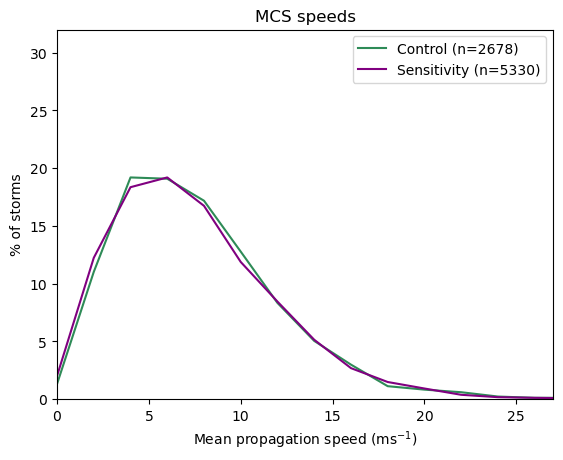

In [16]:
bins=[]
for props in [MCS_props, sens_props, lam_mcs_prop]:
    mx=np.ceil(props["ltime"].max())
    bins.append(stats.binned_statistic(props["speeds"],props["speeds"],statistic='count',bins=(mx+mx%2)/2 + 1,range=(-1,mx+mx%2 + 1)))
                
plt.plot(bins[0].bin_edges[:-1]+1,100*bins[0].statistic/np.sum(bins[0].statistic),label="Control (n={:.0f})".format(np.sum(bins[0].statistic)),color="seagreen")#"darkseagreen")
plt.plot(bins[1].bin_edges[:-1]+1,100*bins[1].statistic/np.sum(bins[1].statistic),label="Sensitivity (n={:.0f})".format(np.sum(bins[1].statistic)),color="purple")#"darkseagreen")
#plt.plot(bins[2].bin_edges[:-1]+1,100*bins[2].statistic/np.sum(bins[2].statistic),label="LAM (n={:.0f})".format(np.sum(bins[2].statistic)),color="maroon")#"mediumturquoise")
plt.legend()
plt.xlabel("Mean propagation speed (ms$^{-1}$)")
plt.ylabel("% of storms")
#plt.xticks(bins[0].bin_edges[::5],np.arange(0,30,5))
plt.xlim([0,27])#improves shear response of intense rainfall from MCSs
plt.ylim([0,32])
plt.title("MCS speeds")

Text(0.5, 1.0, 'MCS propagation')

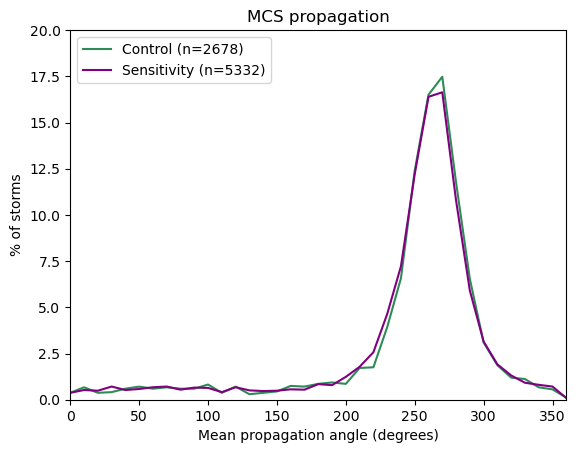

In [17]:
bins=[]
for props in [MCS_props,sens_props,lam_mcs_prop]:
    bins.append(stats.binned_statistic(props["dirs"],props["dirs"],statistic='count',bins=37,range=(-5,365)))

plt.plot(bins[0].bin_edges[:-1]+5,100*bins[0].statistic/np.sum(bins[0].statistic),label="Control (n={:.0f})".format(np.sum(bins[0].statistic)),color="seagreen")
plt.plot(bins[1].bin_edges[:-1]+5,100*bins[1].statistic/np.sum(bins[1].statistic),label="Sensitivity (n={:.0f})".format(np.sum(bins[1].statistic)),color="purple")
#plt.plot(bins[2].bin_edges[:-1]+5,100*bins[2].statistic/np.sum(bins[2].statistic),label="kscale LAM (n={:.0f})".format(np.sum(bins[2].statistic)),color="maroon")
plt.legend()
plt.xlabel("Mean propagation angle (degrees)")
plt.ylabel("% of storms")
#plt.xticks(bins[0].bin_edges[:-1:5],[int(i) for i in (bins[0].bin_edges[:-1:5]+5)])
plt.xlim([0,360])
plt.ylim([0,20])
plt.title("MCS propagation")

Text(0.5, 1.0, 'MCS lifetimes')

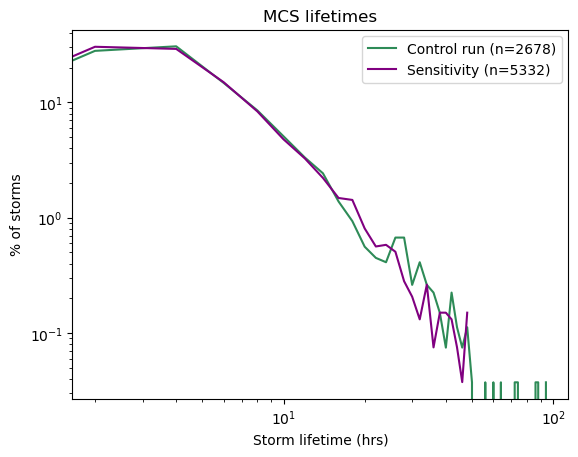

In [18]:
bins=[]
for props in [MCS_props,sens_props,lam_mcs_prop]:
    mx=np.ceil(props["ltime"].max())
    bins.append(stats.binned_statistic(props["ltime"],props["ltime"],statistic='count',bins=(mx+mx%2)/2 + 1,range=(-1,mx+mx%2 + 1)))
                
plt.plot(bins[0].bin_edges[:-1]+1,100*bins[0].statistic/np.sum(bins[0].statistic),label="Control run (n={:.0f})".format(np.sum(bins[0].statistic)),color="seagreen")#"darkseagreen")
plt.plot(bins[1].bin_edges[:-1]+1,100*bins[1].statistic/np.sum(bins[1].statistic),label="Sensitivity (n={:.0f})".format(np.sum(bins[1].statistic)),color="purple")#"mediumturquoise")
#plt.plot(bins[2].bin_edges[:-1]+5,100*bins[2].statistic/np.sum(bins[2].statistic),label="kscale LAM (n={:.0f})".format(np.sum(bins[2].statistic)),color="maroon")
plt.legend()
plt.xlabel("Storm lifetime (hrs)")
plt.xscale("log")
plt.ylabel("% of storms")
plt.yscale("log")
plt.title("MCS lifetimes")

In [19]:
MCS_data["start_time"]=pd.to_datetime(MCS_data["start_time"])

for hr in range(int((MCS_data.shape[1] - 6)/10)):
    MCS_data["hour_%02d"%hr]=(MCS_data["start_time"]+pd.Timedelta(hr,"h")).dt.hour[~pd.isna(MCS_data["area_%02d"%hr])]

In [20]:
for hr in range(int((sens_data.shape[1] - 6)/8)):
    sens_data["hour_%02d"%hr]=(sens_data["start_time"]+pd.Timedelta(hr,"h")).dt.hour[~pd.isna(sens_data["area_%02d"%hr])]

In [21]:
for hr in range(int((sens_data_day1.shape[1] - 6)/8)):
    sens_data_day1["hour_%02d"%hr]=(sens_data_day1["start_time"]+pd.Timedelta(hr,"h")).dt.hour[~pd.isna(sens_data_day1["area_%02d"%hr])]
for hr in range(int((sens_data_day2.shape[1] - 6)/8)):
    sens_data_day2["hour_%02d"%hr]=(sens_data_day2["start_time"]+pd.Timedelta(hr,"h")).dt.hour[~pd.isna(sens_data_day2["area_%02d"%hr])]

In [22]:
lam_data=pd.read_csv("/home/users/bmaybee/LMCS/Cold_pools_expt/MCS_tracks/WafricaEXT_lam_km2p2_RAL3p2_MCS_tracks.csv")

In [23]:
lam_data["start_time"]=pd.to_datetime(lam_data["start_time"],format="%Y%m%d_%H")

for hr in range(int((lam_data.shape[1] - 4)/8)):
    lam_data["hour_%02d"%hr]=(lam_data["start_time"]+pd.Timedelta(hr,"h")).dt.hour[~pd.isna(lam_data["area_%02d"%hr])]

Text(0.5, 1.0, 'MCS diurnal cycle')

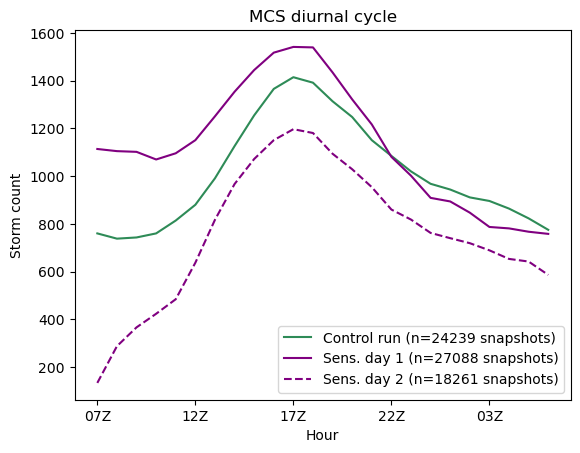

In [24]:
bins=[]
for props in [MCS_data, sens_data_day1, sens_data_day2]:
    hours=props.filter(regex="hour").values.flatten()
    hours=hours[~np.isnan(hours)]
    stat=stats.binned_statistic(hours,hours,statistic='count',bins=24,range=(0,24))
    df=pd.DataFrame(np.vstack([stat.bin_edges[:-1],stat.statistic]).T,columns=["Hour","Count"])
    df=pd.concat([df.iloc[7:],df.iloc[:7]])
    df.index=["%02dZ"%i for i in df.index]
    bins.append(df)
                
#plt.plot(np.concatenate((bins[0].bin_edges[6:-1],bins[0].bin_edges[:6])),np.concatenate((bins[0].statistic[6:],bins[0].statistic[:6])),#,/np.sum(bins[0].statistic),
#         label="Control run (n={:.0f} snapshots)".format(np.sum(bins[0].statistic)),color="seagreen")#"darkseagreen")
#plt.plot(np.concatenate((bins[1].bin_edges[6:-1],bins[1].bin_edges[:6])),np.concatenate((bins[1].statistic[6:],bins[1].statistic[:6])),#/np.sum(bins[1].statistic),
#         label="Sensitivity (n={:.0f} snapshots)".format(np.sum(bins[1].statistic)),color="purple")#"mediumturquoise")
#plt.plot(bins[2].bin_edges[:-1],100*bins[2].statistic/np.sum(bins[2].statistic),label="kscale LAM (n={:.0f} snapshots)".format(np.sum(bins[2].statistic)),color="maroon")#"mediumturquoise")
fig,ax=plt.subplots()
bins[0].Count.plot(ax=ax,label="Control run (n={:.0f} snapshots)".format(bins[0].Count.sum()),color="seagreen")
bins[1].Count.plot(ax=ax,label="Sens. day 1 (n={:.0f} snapshots)".format(bins[1].Count.sum()),color="purple")
bins[2].Count.plot(ax=ax,label="Sens. day 2 (n={:.0f} snapshots)".format(bins[2].Count.sum()),color="purple",ls="--")
plt.legend()
plt.xlabel("Hour")
#plt.xlim([0,23])
plt.ylabel("Storm count")
plt.title("MCS diurnal cycle")

In [25]:
def get_diurnal_var(MCS_data,var):
    diurnal_dict={}
    for hr in np.arange(24):
        diurnal_dict["%02d"%hr]=[]
        
    for i in range(len(MCS_data)):
        storm=MCS_data.iloc[i]
        t=storm.start_time
        if t==storm.sim_start:
            continue
        storm=storm.filter(regex=var).dropna()
        for h in range(len(storm)):
            hr=(t+pd.Timedelta(h,"h")).hour
            # Remove entry of features from storms killed by configuration - causes artificial spikes in DC
            if t+pd.Timedelta(h,"h")==MCS_data.sim_end.iloc[i]:
                continue
            diurnal_dict["%02d"%hr].append(storm.iloc[h])

    return diurnal_dict

In [26]:
def plot_var_dc(var,sens_day="all"):
    dcycs=[]
    dcycs.append(get_diurnal_var(MCS_data,var))
    len1=len(MCS_data[(MCS_data["start_time"]+pd.Timedelta(1,"h")!=MCS_data["sim_end"])])
    
    sens_str=" day "
    if sens_day=="all":
        sens_area_dc=get_diurnal_var(sens_data,var)
        sens_str=", all"
        len2=len(sens_data[(sens_data["start_time"]+pd.Timedelta(1,"h")!=sens_data["sim_end"])])
    elif sens_day=="sep":
        dcycs.append(get_diurnal_var(sens_data_day1,var))
        dcycs.append(get_diurnal_var(sens_data_day2,var))
        sens_str=sens_str+"1"
        sens_str2=" day 2"
        len2=len(sens_data_day1[(sens_data_day1["start_time"]+pd.Timedelta(1,"h")!=sens_data_day1["sim_end"])])
        len3=len(sens_data_day2[(sens_data_day2["start_time"]+pd.Timedelta(1,"h")!=sens_data_day2["sim_end"])])
    elif sens_day=="1":
        sens_area_dc=get_diurnal_var(sens_data_day1,var)
        sens_str=sens_str+"1"
        len2=len(sens_data[(sens_data_day1["start_time"]+pd.Timedelta(1,"h")!=sens_data_day1["sim_end"])])
    elif sens_day=="2":
        sens_area_dc=get_diurnal_var(sens_data_day2,var)
        sens_str=sens_str+"2"
        len2=len(sens_data[(sens_data_day2["start_time"]+pd.Timedelta(1,"h")!=sens_data_day2["sim_end"])])

    dcycs_df=[]
    for dict in dcycs:
        for hr in np.arange(24):
            dict["%02d"%hr]=np.nanmean(dict["%02d"%hr])
        df=pd.Series(dict)
        df=pd.concat([df.iloc[7:],df.iloc[:7]])      
        dcycs_df.append(df)

    dcycs_df[0].plot(label="Control run (n={:.0f})".format(len1),color="seagreen")#"darkseagreen")
    dcycs_df[1].plot(label="Sens.{} (n={:.0f})".format(sens_str,len2),color="purple")#"mediumturquoise")
    if sens_day=="sep":
        dcycs_df[2].plot(label="Sens.{} (n={:.0f})".format(sens_str2,len3),color="purple",ls="--")
    #plt.plot(bins[2].bin_edges[:-1],100*bins[2].statistic/np.sum(bins[2].statistic),label="kscale LAM (n={:.0f} snapshots)".format(np.sum(bins[2].statistic)),color="maroon")#"mediumturquoise")
    plt.legend()
    plt.xlabel("Hour")
    plt.xlim([0,23])
    if "rain" in var:
        unit=" (mm/hr)"
    elif "tm" in var:
        unit=" (K)"
    elif "area" in var:
        unit=" (km2)"
    else:
        unit=""
    plt.ylabel(var+unit)
    plt.title("Diurnal cycle of MCS "+var)

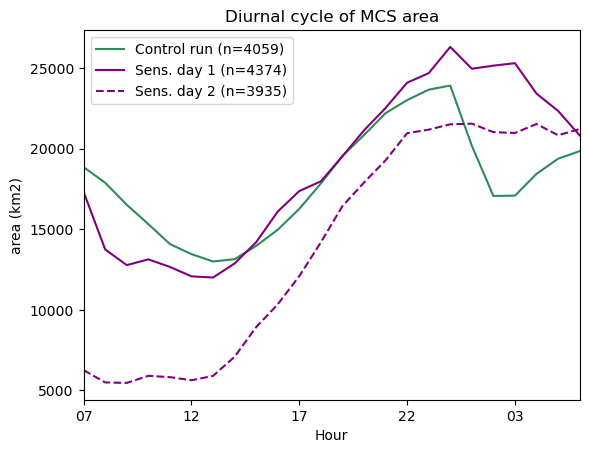

In [27]:
plot_var_dc("area",sens_day="sep")

In [29]:
# Park diurnal cycle of rainfall for now - population of rainfall values in sens track tables not quite right. 
#plot_var_dc("rain_vol")
# plot_var_dc("rain_max")

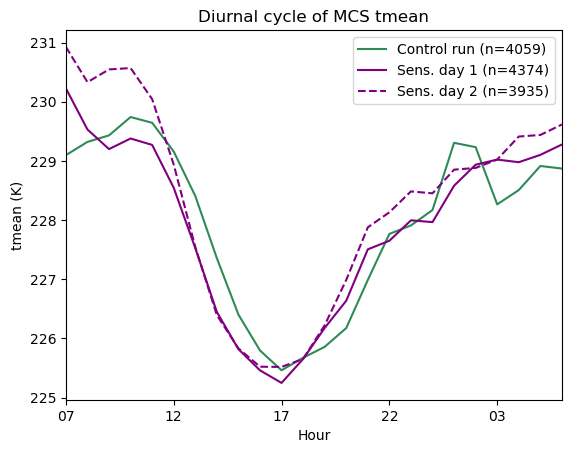

In [30]:
plot_var_dc("tmean",sens_day="sep")

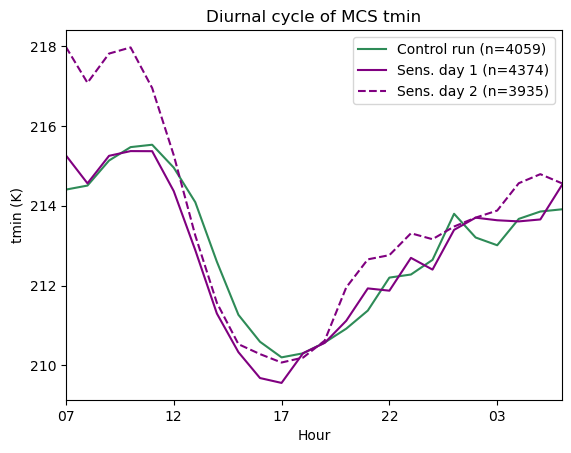

In [31]:
plot_var_dc("tmin",sens_day="sep")

In [32]:
bins=[]
for props in [MCS_data,sens_data_day1,sens_data_day2]:
    hours=np.zeros(len(props))
    for i in range(len(props)):
        storm_locs=props.iloc[i].dropna()
        #MCS area threshold; 11km ~ 0.1 degree resolution of k-scale gws analysis grid. Change if different!
        ltime = len(storm_locs.filter(regex="area"))
        etime = storm_locs["start_time"] + pd.Timedelta(ltime,"h")
        # Remove storms which are killed by simulation ending rather than natural dissipation - causes artifical large spike if included
        if etime==storm_locs["sim_end"]:
            hours[i]=np.NaN
        else:
            hours[i] = etime.hour
    hours=hours[~np.isnan(hours)]
    #bins.append(stats.binned_statistic(hours,hours,statistic='count',bins=24,range=(0,24)))
    stat=stats.binned_statistic(hours,hours,statistic='count',bins=24,range=(0,24))
    df=pd.DataFrame(np.vstack([stat.bin_edges[:-1],stat.statistic]).T,columns=["Hour","Count"])
    df=pd.concat([df.iloc[7:],df.iloc[:7]])
    df.index=["%02dZ"%i for i in df.index]
    bins.append(df)

Text(0.5, 1.0, 'MCS dissipation time')

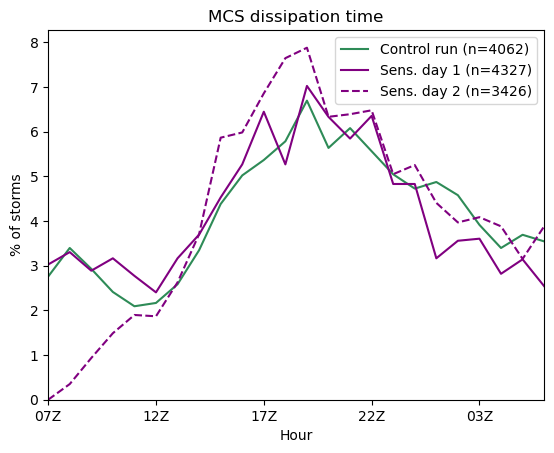

In [33]:
(100*bins[0].Count/bins[0].Count.sum()).plot(label="Control run (n={:.0f})".format(bins[0].Count.sum()),color="seagreen")
(100*bins[1].Count/bins[1].Count.sum()).plot(label="Sens. day 1 (n={:.0f})".format(bins[1].Count.sum()),color="purple")
(100*bins[2].Count/bins[2].Count.sum()).plot(label="Sens. day 2 (n={:.0f})".format(bins[2].Count.sum()),color="purple",ls="--")
#plt.plot(bins[0].bin_edges[:-1],100*bins[0].statistic/np.sum(bins[0].statistic),label="Control run (n={:.0f})".format(np.sum(bins[0].statistic)),color="seagreen")#"darkseagreen")
#plt.plot(bins[1].bin_edges[:-1],100*bins[1].statistic/np.sum(bins[1].statistic),label="Sensitivity (n={:.0f})".format(np.sum(bins[1].statistic)),color="purple")#"mediumturquoise")
#plt.plot(bins[0].bin_edges[:-1],bins[0].statistic,label="Control run (n={:.0f})".format(np.sum(bins[0].statistic)),color="seagreen")#"darkseagreen")
#plt.plot(bins[1].bin_edges[:-1],bins[1].statistic,label="Sensitivity (n={:.0f})".format(np.sum(bins[1].statistic)),color="maroon")#"mediumturquoise")
plt.legend()
plt.xlabel("Hour")
plt.xlim([0,23])
plt.ylim([0,None])
plt.ylabel("% of storms")
plt.title("MCS dissipation time")

Text(0.5, 1.0, 'MCS initiation time')

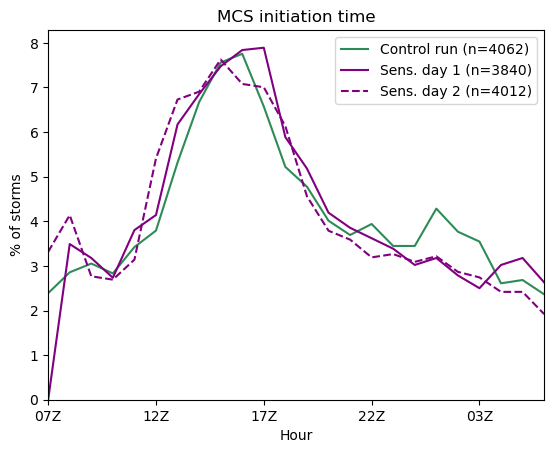

In [34]:
bins=[]
for i, props in enumerate([MCS_data, sens_data_day1, sens_data_day2]):
    if i==1:
        props=props[props.start_time+pd.Timedelta(2,"d")!=props.sim_end]
    hours=props["start_time"].dt.hour
    #bins.append(stats.binned_statistic(hours,hours,statistic='count',bins=24,range=(0,24)))
    stat=stats.binned_statistic(hours,hours,statistic='count',bins=24,range=(0,24))
    df=pd.DataFrame(np.vstack([stat.bin_edges[:-1],stat.statistic]).T,columns=["Hour","Count"])
    df=pd.concat([df.iloc[7:],df.iloc[:7]])
    df.index=["%02dZ"%i for i in df.index]
    bins.append(df)

(100*bins[0].Count/bins[0].Count.sum()).plot(label="Control run (n={:.0f})".format(bins[0].Count.sum()),color="seagreen")
(100*bins[1].Count/bins[1].Count.sum()).plot(label="Sens. day 1 (n={:.0f})".format(bins[1].Count.sum()),color="purple")
(100*bins[2].Count/bins[2].Count.sum()).plot(label="Sens. day 2 (n={:.0f})".format(bins[2].Count.sum()),color="purple",ls="--")
#plt.plot(bins[0].bin_edges[:-1],100*bins[0].statistic/np.sum(bins[0].statistic),label="Control run (n={:.0f})".format(np.sum(bins[0].statistic)),color="seagreen")#"darkseagreen")
#plt.plot(bins[1].bin_edges[:-1],100*bins[1].statistic/np.sum(bins[1].statistic),label="Sens. day 1 (n={:.0f})".format(np.sum(bins[1].statistic)),color="purple")#"mediumturquoise")
#plt.plot(bins[2].bin_edges[:-1],100*bins[2].statistic/np.sum(bins[2].statistic),label="Sens. day 2 (n={:.0f})".format(np.sum(bins[2].statistic)),color="purple",ls="--")
plt.legend()
plt.xlabel("Hour")
plt.xlim([0,23])
plt.ylim([0,None])
plt.ylabel("% of storms")
plt.title("MCS initiation time")

Text(0.5, 1.0, 'MCS mean lifetime from initiation hour')

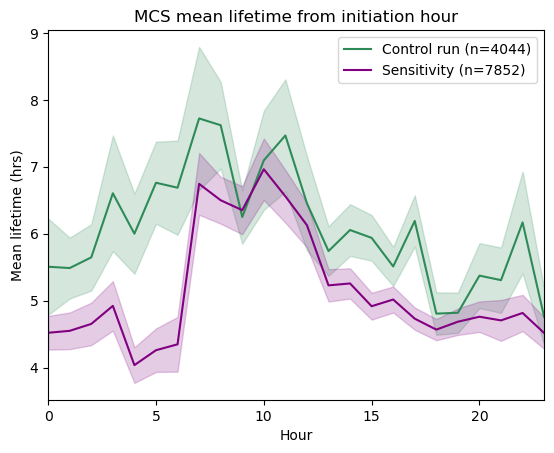

In [35]:
bins=[]
for i, props in enumerate([MCS_data, sens_data]):
    ltimes=np.zeros((24,3))
    props=props[props.start_time!=props.sim_start]
    for hr in np.arange(0,24):
        counts=props[props.start_time.dt.hour==hr].filter(regex="area").count(axis=1)
        ltimes[hr,0]=counts.mean()
        ltimes[hr,1]=counts.std()/np.sqrt(len(counts))
        ltimes[hr,2]=len(counts)
    bins.append(ltimes)
                
plt.plot(np.arange(0,24),bins[0][:,0],label="Control run (n={:.0f})".format(bins[0][:,2].sum()),color="seagreen")#"darkseagreen")
plt.fill_between(np.arange(0,24),bins[0][:,0]-bins[0][:,1],bins[0][:,0]+bins[0][:,1],color="seagreen",alpha=0.2)
plt.plot(np.arange(0,24),bins[1][:,0],label="Sensitivity (n={:.0f})".format(bins[1][:,2].sum()),color="purple")#"mediumturquoise")
plt.fill_between(np.arange(0,24),bins[1][:,0]-bins[1][:,1],bins[1][:,0]+bins[1][:,1],color="purple",alpha=0.2)
plt.legend()
plt.xlabel("Hour")
plt.xlim([0,23])
plt.ylabel("Mean lifetime (hrs)")
plt.title("MCS mean lifetime from initiation hour")

In [36]:
MCS_data[MCS_data.start_time.dt.hour==0].filter(regex="area").count(axis=1).mean()

5.507142857142857

In [37]:
MCS_env_data=pd.read_csv("~/LMCS/LMCS_Wafrica_sim/storm_tracking/Tables/Control_run_MCS_tracks_env.csv")
MCS_env_data["time"] = pd.to_datetime(MCS_env_data["time"])
#MCS_data["tmin"] = empbt(MCS_data["tmin"])
#MCS_data['area'] = 11.1**2 * MCS_data['area']

MCS_env_data["hour"] = MCS_env_data["time"].dt.hour
MCS_env_data['q850'] = 1000*MCS_env_data['q850'] # convert from kg/kg to g/kg
MCS_env_data['q925'] = 1000*MCS_env_data['q925']
MCS_env_data["PS_u"] = MCS_env_data["PS_u"] / 3.6 # convert from km/h to m/s
MCS_env_data["PS_v"] = MCS_env_data["PS_v"] / 3.6
MCS_env_data["speed"] = np.sqrt(MCS_env_data["PS_u"]**2 + MCS_env_data["PS_v"]**2)

#Apply MCS criteria:
MCS_env_data = MCS_env_data[(MCS_env_data["rain_vol"]  > 0) & (MCS_env_data["rain_max"]  > 1) & (MCS_env_data["area"]  > 5000) & (MCS_env_data["hour"]>15)]

#MCS_env_data=MCS_data[(MCS_env_data["hour"].isin([16,17,18,19]))] # some tables go outside of core hours
#                  & (MCS_data["rain_max"] > 1) & (MCS_data["q925"] > 8)  ]
#non_triv=MCS_data.iloc[:,2:-1].dropna(axis=0,how="all")
#MCS_data=MCS_data.loc[non_triv.index]

In [38]:
MCS_env_data["rain_mean"]=MCS_env_data["rain_vol"]/(MCS_env_data["area"]/1.5**2)

3927
3689


<Axes: title={'center': 'LMCS Control run, Wafrica: max rain\n16-22UTC MCSs ($\\bf n=3689$) '}, xlabel='u650 - u850 (m s$^{-1}$)', ylabel='Total column water (mm)'>

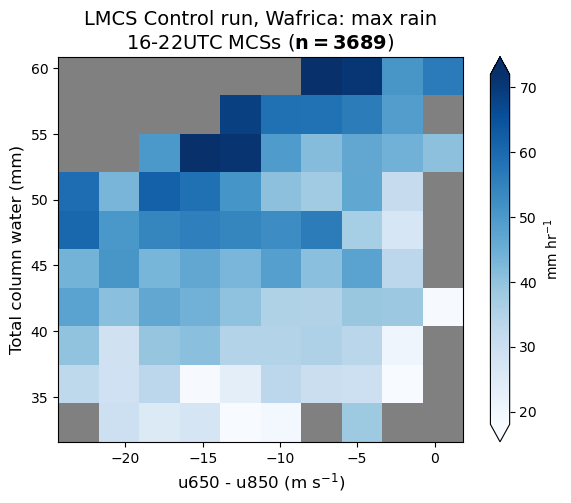

In [39]:
#fig,ax=plt.subplots()
plot_hist(MCS_env_data,"Wafrica","LMCS Control run","rain_max")

In [40]:
def linear_fit(x,a0,a1):
    return a0 + x * a1

def fit_trend(MCS_data,MCS_var,bin_var="ushear650_850",red_var="tcw",grid_spec=10,cut_off=5,max_pcle=0.99,min_pcle=0.01,rval=False):
    try:
        MCS_data=MCS_data[MCS_data["psfc"]>850]
    except:
        pass
    """
        try:
            plev=int(shear_var[-3:])
            try:
                plev=np.max(int(moist_var[-3:]),plev)
            except:
                pass
            MCS_data=MCS_data[MCS_data["psfc"]>plev]
            MCS_datas[i]=MCS_data
        except:
            pass
    """
    y, y_err, counts = bin_1d(MCS_data,MCS_var,bin_var,red_var,grid_spec=grid_spec,cut_off=cut_off,max_pcle=max_pcle,min_pcle=min_pcle)
    y, y_err = y.dropna(dim="x"), y_err.dropna(dim="x")
    y=y.where(y_err)
    X = y["x"].values

    #fit = sm.WLS(y.values, sm.add_constant(X), weights=y_err.values).fit()
    popt, pcov = curve_fit(linear_fit, X, y.values, sigma=y_err.values, absolute_sigma=True)
    if rval:
        print(stats.pearsonr(y.x,y))
    #out = linear_fit(X, *popt)
    # returns 1D histogram, gradient, intercept

    
    tval=abs(popt[1])/np.sqrt(np.diag(pcov)[1])
    t_ref=stats.distributions.t.ppf(1.0-0.5*0.05, grid_spec-2)
    p = 2*stats.distributions.t.sf(tval, grid_spec-2)
    if tval < t_ref:
        print("Fit gradient not p<0.05 significant %.3f < %.3f , p = %.3f" % (tval, t_ref,p))
    return(y,popt,np.diag(pcov))

In [41]:
from scipy.optimize import curve_fit

In [42]:
out=fit_trend(MCS_env_data,"rain_max",max_pcle=0.95,min_pcle=0.05)

Text(0, 0.5, 'Max rain')

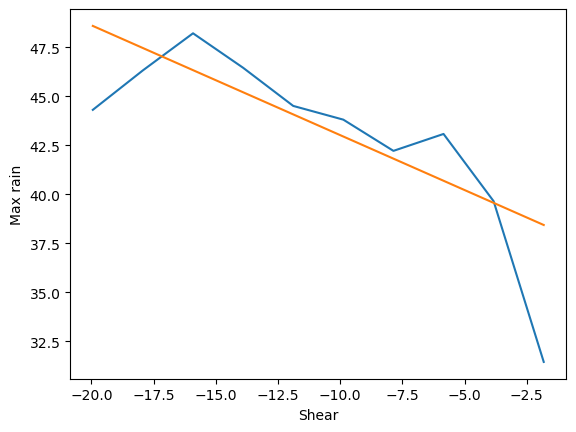

In [43]:
out[0].plot()
plt.plot(out[0].x,out[1][0]+out[1][1]*out[0].x.values)
plt.xlabel("Shear")
plt.ylabel("Max rain")

In [44]:
out=fit_trend(MCS_env_data,"rain_max",bin_var="tcw",red_var="ushear650_850",max_pcle=0.95,min_pcle=0.05)

Text(0, 0.5, 'Max rain')

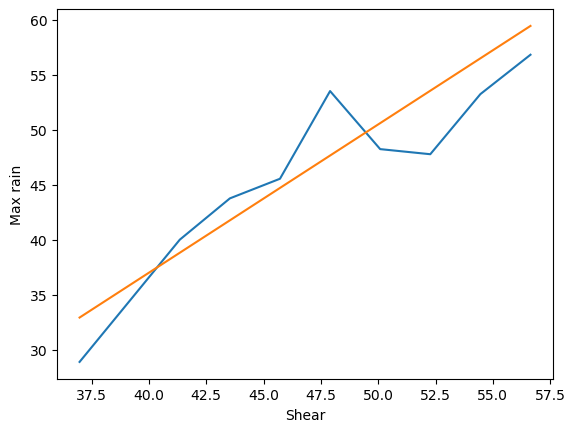

In [45]:
out[0].plot()
plt.plot(out[0].x,out[1][0]+out[1][1]*out[0].x.values)
plt.xlabel("Shear")
plt.ylabel("Max rain")